# Mise en place de l'environnement

### Paramètres

In [1]:
rep_projet = 'C:/Users/u32118508/OneDrive - UPEC/Bureau/PyBooks/Applications/Scoring/'
rep_input  = rep_projet+ 'Input/'
rep_intermed  = rep_projet+ 'Intermed/'

### Import des packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score , accuracy_score, precision_score, recall_score,  f1_score, roc_curve, auc
import pickle


### Import des fonctions personnelles

Le script functions_ml.py dans le répertoire script contient différentes fonctions personnelles pour réaliser ce projet.
Pour rendre le notebook plus visible, il est préferable de mettre les  fonctions  à part et les importer

In [3]:
import functions_ml

In [4]:
#aide sur la fonction ... 
help(functions_ml.features_ordering)

Help on function features_ordering in module functions_ml:

features_ordering(df, feature_names, target)
    Retourne un df avec une ligne par feature par ordre décroissant des T de Schupprow en fonction d'une variable cible Y
    
    Parametres :
        X : pandas dataframe
        feature_names : liste des nom des colonnes dont l'on souhaite avoir les stats du chi2
            => ne pas mettre d'id ou de variables numériques avec trop de modalité
        target : nom de la variable cible (Y)
    
    Exemple d'appel :
        
        features_ordering =  features_ordering(  df = df_xy 
                                               , feature_names = ['gender','csp','region']
                                               , target        = 'target' )



### Paramètres d'affichage de pandas

In [4]:
pd.set_option('display.max_rows', 350)    # permet de voir 350 lignes au max
pd.set_option('display.max_columns', 350) # permet de voir 350 colonnes au max
pd.set_option('display.width', 1000)

# Compréhension des données

## Données utilisées


- le fichier source vient de : https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
        
-il a été fourni par :    Professor Dr. Hans Hofmann
                        Institut fur Statistik und Okonometrie
                        Universit at Hamburg
                        FB Wirtschaftswissenschaften
                        Von-Melle-Park 5
                        2000 Hamburg 13 

## Lecture des données

In [5]:
df = pd.read_csv(rep_input+'german_scoring_data.txt', sep=';'
                    , encoding='latin_1', decimal = ','
                    , keep_default_na=False , na_values = [ '', ' ', '  '])

In [7]:
df['Savings account/bonds'].value_cou

Index(['subsidiary', 'customer_id', 'year', 'risk', 'Status of existing checking account', 'Duration in month', 'Credit history', 'Purpose', 'Credit amount', 'Savings account/bonds', 'Present employment since', 'Installment rate in percentage of disposable income', 'Personal status and sex', 'Other debtors / guarantors', 'RGPD KO', 'Present residence since', 'Property', 'Age in years', 'Evaluation', 'Other installment plans', 'Housing', 'Number of existing credits at this bank', 'Job', 'Number of people being liable to provide maintenance for', 'Téléphone', 'foreign worker'], dtype='object')

## Analyse du contenu de la table

  - le nb d'obs et de variables
  - les 1ères lignes
  - les dernières lignes
  - le type de chaque variable
  - le % de missing de chaque variable
  - le résumé de chaque variable (describe)
  - la présence de doublon sur l'identifiant
  - le type et nb de modalités <> pour chaque variable



In [7]:
functions_ml.valid_df(df.iloc[:,0: 5],  df_name= 'german_data', id_var='customer_id')

Synthese de la table
=== DF : german_data
nb de lignes et de colonnes
(800, 5)

type, missing et nb de modalites <>
                                column    type  missing_count  missing_rate  nb_labels                        value_1          value_2                 value_3              value_4         value_5      value_6      value_7      value_8      value_9     value_10     value_11     value_12     value_13     value_14     value_15     value_16     value_17     value_18     value_19     value_20
0                           subsidiary  object              0           0.0          1               german (800 obs)             None                    None                 None            None         None         None         None         None         None         None         None         None         None         None         None         None         None         None         None
1                          customer_id   int64              0           0.0        800                

,column,type,missing_count,missing_rate,nb_labels,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20
0,subsidiary,object,0,0.0,1,german (800 obs),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,customer_id,int64,0,0.0,800,675 (1 obs),680 (1 obs),490 (1 obs),506 (1 obs),39 (1 obs),735 (1 obs),120 (1 obs),953 (1 obs),824 (1 obs),172 (1 obs),667 (1 obs),566 (1 obs),278 (1 obs),234 (1 obs),170 (1 obs),993 (1 obs),242 (1 obs),706 (1 obs),512 (1 obs),849 (1 obs)
2,year,int64,0,0.0,5,2012 (165 obs),2013 (163 obs),2014 (162 obs),2011 (158 obs),2010 (152 obs),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,risk,int64,0,0.0,2,0 (558 obs),1 (242 obs),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Status of existing checking account,object,0,0.0,4,no checking account (315 obs),<0 DM (224 obs),0 <= <200 DM (209 obs),>= 200 DM (52 obs),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


# Recodages des variables explicatives

In [8]:
## *texte en italique*## Définition des listes de variables suite à l'analyse dans Excel

In [9]:
numeric_vars = ['Credit amount', 'Age in years', 'Duration in month', 'Evaluation']
other_vars = ['customer_id', 'month']
target = 'risk'
vars_to_delete = ['subsidiary']
qualitative_vars = list(df.columns.difference(numeric_vars + other_vars + vars_to_delete + [ target ]))

#futures variables numériques recodées en qualitative en rajoutant un suffix '_q'
new_qualitative_vars = qualitative_vars + [c + '_q' for c in numeric_vars]

## Découpage en tranches des variables numériques

- il ne faut se baser que sur les données du Train

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html
- https://pbpython.com/pandas-qcut-cut.html

In [10]:
for c in numeric_vars:
    print(c)
    df[c + '_q'] = pd.qcut(df[c], q=5, duplicates = 'drop')
    #les variables catégorielles sont un peu galère à gérer ... 
    #elles n'aiment pas les fillna par exemple
    #par contre en faisant cette transformation, on perd l'ordre des modalités...
    df[c + '_q'] = df[c + '_q'].astype(str) 
    print(df[c + '_q'].value_counts(dropna=False))

#on fait ça pour avoir une 1ère impression mais ensuite on fera ce recodage :
    # --> soit à la main :
    #     - soit apres découpage en 10 classes
    #     - soit en regardant un graph
    # -->soit en automatique :
    #     - avec un arbre de décision 
df

Credit amount
(249.999, 1275.0]    162
(2915.2, 4843.2]     160
(4843.2, 18424.0]    160
(1924.0, 2915.2]     159
(1275.0, 1924.0]     159
Name: Credit amount_q, dtype: int64
Age in years
(18.999, 26.0]    191
(30.0, 36.0]      169
(44.2, 75.0]      160
(36.0, 44.2]      140
(26.0, 30.0]      140
Name: Age in years_q, dtype: int64
Duration in month
(3.999, 12.0]    277
(15.0, 24.0]     274
(30.0, 72.0]     150
(12.0, 15.0]      55
(24.0, 30.0]      44
Name: Duration in month_q, dtype: int64
Evaluation
(62.78, 81.82]    160
(81.82, 99.9]     160
(24.68, 45.66]    160
(5.199, 24.68]    160
(45.66, 62.78]    160
Name: Evaluation_q, dtype: int64


,subsidiary,customer_id,year,risk,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,RGPD KO,Present residence since,Property,Age in years,Evaluation,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Téléphone,foreign worker,Credit amount_q,Age in years_q,Duration in month_q,Evaluation_q
0,german,675,2013,1,no checking account,21,delay in paying off,business,2580,500 <= < 1000 DM,<1 years,4,male:single,none,NaN,2,real estate,41,68.7,bank,own,1,unskilled - resident,2,none,yes,"(1924.0, 2915.2]","(36.0, 44.2]","(15.0, 24.0]","(62.78, 81.82]"
1,german,234,2011,0,0 <= <200 DM,18,existing credits paid back duly till now,radio/télévision,866,<100 DM,1<= < 4 years,4,male:married/widowed,guarantor,3.0,2,real estate,25,98.7,none,own,1,unskilled - resident,1,none,yes,"(249.999, 1275.0]","(18.999, 26.0]","(15.0, 24.0]","(81.82, 99.9]"
2,german,740,2013,1,0 <= <200 DM,30,no credits taken,business,4280,100 <= <500 DM,1<= < 4 years,4,female:divorced/separated/married,none,NaN,4,car or other,26,83.7,none,rent,2,unskilled - resident,1,none,yes,"(2915.2, 4843.2]","(18.999, 26.0]","(24.0, 30.0]","(81.82, 99.9]"
3,german,866,2014,0,no checking account,15,existing credits paid back duly till now,furniture/equipment,2221,500 <= < 1000 DM,1<= < 4 years,2,female:divorced/separated/married,none,NaN,4,car or other,20,34.2,none,rent,1,skilled employee / official,1,none,yes,"(1924.0, 2915.2]","(18.999, 26.0]","(12.0, 15.0]","(24.68, 45.66]"
4,german,524,2012,0,no checking account,24,existing credits paid back duly till now,car (used),3488,100 <= <500 DM,4<= <7 years,3,female:divorced/separated/married,none,2.0,4,car or other,23,8.0,none,own,1,skilled employee / official,1,none,yes,"(2915.2, 4843.2]","(18.999, 26.0]","(15.0, 24.0]","(5.199, 24.68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,german,767,2013,1,<0 DM,30,existing credits paid back duly till now,furniture/equipment,3108,<100 DM,<1 years,2,male:divorced/separated,none,NaN,4,savings agreement/life insurance,31,84.0,none,own,1,unskilled - resident,1,none,yes,"(2915.2, 4843.2]","(30.0, 36.0]","(24.0, 30.0]","(81.82, 99.9]"
796,german,415,2012,1,<0 DM,24,existing credits paid back duly till now,car (new),1381,no savings account,1<= < 4 years,4,female:divorced/separated/married,none,1.0,2,savings agreement/life insurance,35,50.7,none,own,1,skilled employee / official,1,none,yes,"(1275.0, 1924.0]","(30.0, 36.0]","(15.0, 24.0]","(45.66, 62.78]"
797,german,729,2013,1,0 <= <200 DM,48,all credits at this bank paid back duly,business,6416,<100 DM,>=7 years,4,female:divorced/separated/married,none,NaN,3,unknown / no property,59,90.6,none,rent,1,skilled employee / official,1,none,yes,"(4843.2, 18424.0]","(44.2, 75.0]","(30.0, 72.0]","(81.82, 99.9]"
798,german,948,2014,0,no checking account,12,existing credits paid back duly till now,car (new),2859,no savings account,unemployed,4,male:single,none,NaN,4,unknown / no property,38,13.0,none,own,1,management/ highly qualified employee,1,yes,yes,"(1924.0, 2915.2]","(36.0, 44.2]","(3.999, 12.0]","(5.199, 24.68]"


les variables pour lesquelles la distritbution des modalités sont differentes est du à la présence des valeurs manquantes?????????

## Traitement des valeurs manquantes

- Vu que l'on discrétise toutes les variables, on va simplement remplacer les valeurs manquantes par une valeur fixe. Ici la ds=iscrétisation des valeurs numériques permettent de prendre en compte les valeurs manquantes.


In [11]:
df = df.fillna('VIDE')

## Regroupements de modalités

- Analyse univariée du lien avec la variable cible

- On analyse les variables selon leur ordre potentiel d'importance (probabilité du test du chi2 croissante)

- **sur l'échantillon Train seulement**

In [12]:
help(functions_ml.summary_table)

Help on function summary_table in module functions_ml:

summary_table(train_Xy, cols_list, target)
    La fonction renvoie un df de synthèse des variables explicatives en fonction d'une target numérique (binaire ok)
    On calcule pour chaque modalité de chaque variable : sa fréquence et fréquence relative et sa moyenne
    
    en + 2 variables :
        - 'nb_values' : nb de modalités de la variables
        - 'nb_rows'   : nb de lignes dans la table (=> identique sur toutes les lignes)
    
    remarque : les valeurs manquantes ne sont pas considérées par défaut
               => si besoin utilisez df=df.fillna('') avant cette fonction
               
        parametres obligatoires:
             train_Xy   : nom du df contenant les variables explicatives et la variable cible
             cols_list  : liste des variables explicatives (plutôt discrètes ou continues avec peu de moda)
                          car la table créé en sortie contiendra une ligne par valeur
                

In [13]:
#Taux moyen par tranche de chaque variable
#la target doit etre numérique
df_stats = functions_ml.summary_table(df, cols_list = new_qualitative_vars , target= target)
df_stats.head()

Credit history
Housing
Installment rate in percentage of disposable income
Job
Number of existing credits at this bank
Number of people being liable to provide maintenance for
Other debtors / guarantors
Other installment plans
Personal status and sex
Present employment since
Present residence since
Property
Purpose
RGPD KO
Savings account/bonds
Status of existing checking account
Téléphone
foreign worker
year
Credit amount_q
Age in years_q
Duration in month_q
Evaluation_q


,nb_values,variable,value,freq,pct_freq,pct_target,nb_rows,target,code_recode,code_recode2,code_recode3
0,5,Age in years_q,"(18.999, 26.0]",191,0.23875,0.382199,800,risk,,,
4,5,Age in years_q,"(26.0, 30.0]",140,0.17500,0.321429,800,risk,,,
3,5,Age in years_q,"(36.0, 44.2]",140,0.17500,0.285714,800,risk,,,
1,5,Age in years_q,"(30.0, 36.0]",169,0.21125,0.266272,800,risk,,,
2,5,Age in years_q,"(44.2, 75.0]",160,0.20000,0.243750,800,risk,,,


In [14]:
#V de Cramer et T de Tschuprow
df_vc =  functions_ml.features_ordering(df , feature_names = new_qualitative_vars , target = target)
print(df_vc)

   target                                           variable      VC      TS     CHI2  p_value
15   risk                Status of existing checking account  0.3282  0.2494  86.1855   0.0000
0    risk                                     Credit history  0.2316  0.1637  42.8947   0.0000
21   risk                                Duration in month_q  0.2143  0.1516  36.7522   0.0000
14   risk                              Savings account/bonds  0.1856  0.1312  27.5471   0.0000
1    risk                                            Housing  0.1369  0.1151  14.9832   0.0006
12   risk                                            Purpose  0.1815  0.1048  26.3576   0.0018
7    risk                            Other installment plans  0.1199  0.1008  11.4974   0.0032
11   risk                                           Property  0.1312  0.0997  13.7772   0.0032
9    risk                           Present employment since  0.1401  0.0991  15.7093   0.0034
19   risk                                    Credi

In [15]:
#Rapprochement des 2 tables et export dans Excel avec un petit formatage
df_stats2 = df_vc.merge(df_stats, on='variable', how='outer')

df_stats2 = df_stats2.rename(columns={  'pct_target':'% risk'
                                      , 'pct_freq'  :'% obs'
                                      , 'freq'      : 'nb obs'
                                      })
f_stats2 =  df_stats2.sort_values(['p_value','TS','variable'], ascending=[True,False,True])

df_stats2.style.format('{0: .0f}',subset=['nb_rows']).\
    background_gradient(subset=['TS','% risk'], cmap='BuGn').\
    to_excel(rep_intermed + 'stats_VC_TS_par_variable.xlsx', engine='openpyxl'
             , index = False
             , freeze_panes = ((1,0))
             , float_format="%.2f"  #on perd la valeur mais c'est bien arrondi
             #, na_rep = '*' #default ''
             ) 

In [16]:
df_stats2.style.format('{0: .0f}',subset=['nb_rows']).\
    background_gradient(subset=['TS','% risk'], cmap='BuGn').\
    to_excel(rep_intermed + 'stats_VC_TS_par_variable.xlsx', engine='openpyxl'
             , index = False
             , freeze_panes = ((1,0))
             , float_format="%.2f"  #on perd la valeur mais c'est bien arrondi
             #, na_rep = '*' #default ''
             ) 

On regroupe les modalités à partir du fichier Excel à l'aide de la fonction **create_new_categ_var**

"""
 à rajouter
"""


on recalcule les stats de VC/TS/proba à partir de ces nouveaux recodages pour les intégrer dans le rapport.

# Analyse de la stabilité des variables

- si une variable est instable, alors il y a de grands risques qu'elle perturbe rapidement le fonctionnement du modèle en production

- **sur l'échantillon Train seulement**

In [17]:
# toujours le même principe sauf que cette fois-ci c'est la variable "month" qui passe en target
df_stability =  functions_ml.features_ordering(df
                                           , feature_names = new_qualitative_vars
                                           , target = 'year')
df_stability = df_stability.sort_values('p_value')
print(df_stability)

   target                                           variable      VC      TS      CHI2  p_value
13   year                                            RGPD KO  0.5787  0.5386  803.7915   0.0000
18   year                                    Credit amount_q  0.0925  0.0925   27.3641   0.0376
2    year  Installment rate in percentage of disposable i...  0.0791  0.0736   14.9982   0.2415
20   year                                Duration in month_q  0.0757  0.0757   18.3264   0.3051
17   year                                     foreign worker  0.0774  0.0547    4.7886   0.3097
14   year                              Savings account/bonds  0.0717  0.0717   16.4354   0.4230
19   year                                     Age in years_q  0.0681  0.0681   14.8395   0.5364
11   year                                           Property  0.0668  0.0621   10.6947   0.5552
9    year                           Present employment since  0.0648  0.0648   13.4311   0.6410
0    year                               

In [18]:
for c in df_stability['variable'][:5]:
    print("--------------------------------------------")
    print('variable : ' + c )
    print("--------------------------------------------")
    df_temp = pd.crosstab(df[c], df['year'], normalize='columns').reset_index()
    print(df_temp.to_string(index=False))
    print()

--------------------------------------------
variable : RGPD KO
--------------------------------------------
RGPD KO     2010     2011     2012  2013  2014
    1.0 0.348684 0.278481 0.290909   0.0   0.0
    2.0 0.322368 0.379747 0.363636   0.0   0.0
    3.0 0.328947 0.341772 0.345455   0.0   0.0
   VIDE 0.000000 0.000000 0.000000   1.0   1.0

--------------------------------------------
variable : Credit amount_q
--------------------------------------------
  Credit amount_q     2010     2011     2012     2013     2014
 (1275.0, 1924.0] 0.223684 0.139241 0.218182 0.196319 0.216049
 (1924.0, 2915.2] 0.203947 0.177215 0.260606 0.202454 0.148148
(249.999, 1275.0] 0.190789 0.265823 0.218182 0.177914 0.160494
 (2915.2, 4843.2] 0.138158 0.234177 0.163636 0.208589 0.253086
(4843.2, 18424.0] 0.243421 0.183544 0.139394 0.214724 0.222222

--------------------------------------------
variable : Installment rate in percentage of disposable income
--------------------------------------------
 Insta

Good news========> Variables stables

# Corrélation entre les variables explicatives

- **sur l'échantillon Train seulement**

In [19]:
#   une fonction features_correlation qui aura deux paramètres 'df' et 'feature_names'
#   elle calculera la corrélation au sens du VC et TS pour chaque couple possible parmi les variables définies dans la liste 'feature_names'
#   elle renverra un dataframe trié avec les couples les + corrélés en premier

## Tableau des couples de variables qualitatives les + corrélées

In [20]:
df_corr =pd.concat(
          [   
              functions_ml.features_ordering(
                                              df,
                                              feature_names = new_qualitative_vars,
                                              target = new_qualitative_var
                                            ) 
             for new_qualitative_var in new_qualitative_vars
          ]
                 )
df_corr = df_corr.sort_values(['p_value','TS'], ascending=[True, False]).\
          rename( columns= {'target' : 'variable_1', 'variable' : 'variable_2'})
#df_corr[:25]

## Heatmap des corrélations

On passe du df des couples de variables à une matrice via la fonction **utils_ml.correlation_list_to_matrix**

In [21]:
#utils_ml.
df_corr_matrix = functions_ml.correlation_list_to_matrix(df_corr, criterion = 'TS')
df_corr_matrix

,Age in years_q,Credit amount_q,Credit history,Duration in month_q,Evaluation_q,Housing,Installment rate in percentage of disposable income,Job,Number of existing credits at this bank,Number of people being liable to provide maintenance for,Other debtors / guarantors,Other installment plans,Personal status and sex,Present employment since,Present residence since,Property,Purpose,RGPD KO,Savings account/bonds,Status of existing checking account,Téléphone,foreign worker,year
Age in years_q,1.0000,0.0869,0.1215,0.0743,0.0604,0.2214,0.0830,0.1149,0.1099,0.2024,0.0410,0.0488,0.1920,0.2252,0.1725,0.1282,0.1075,0.0571,0.0843,0.0951,0.1384,0.0165,0.0681
Credit amount_q,0.0869,1.0000,0.0886,0.3364,0.0481,0.1324,0.1713,0.1985,0.0696,0.0657,0.0694,0.0585,0.1343,0.0880,0.0790,0.1992,0.1864,0.0629,0.0805,0.0879,0.1704,0.0641,0.0925
Credit history,0.1215,0.0886,1.0000,0.1251,0.0779,0.0942,0.0613,0.0600,0.3511,0.0854,0.0845,0.1692,0.0909,0.1089,0.0836,0.0888,0.1424,0.0737,0.0785,0.1303,0.0510,0.0530,0.0646
Duration in month_q,0.0743,0.3364,0.1251,1.0000,0.0598,0.1168,0.0954,0.1452,0.0885,0.0651,0.0531,0.0784,0.0847,0.0769,0.0751,0.1786,0.1401,0.0721,0.0746,0.0779,0.1281,0.1127,0.0757
Evaluation_q,0.0604,0.0481,0.0779,0.0598,1.0000,0.0520,0.0632,0.0611,0.0669,0.0214,0.0600,0.0418,0.0710,0.0550,0.0707,0.0348,0.0743,0.0610,0.0778,0.0730,0.0945,0.0444,0.0598
Housing,0.2214,0.1324,0.0942,0.1168,0.0520,1.0000,0.0570,0.1281,0.0848,0.0995,0.0624,0.0906,0.1866,0.1345,0.2338,0.5013,0.1410,0.0276,0.0488,0.1018,0.1181,0.0611,0.0475
Installment rate in percentage of disposable income,0.0830,0.1713,0.0613,0.0954,0.0632,0.0570,1.0000,0.0927,0.0515,0.0764,0.0264,0.0391,0.1020,0.1061,0.0676,0.0483,0.1098,0.0661,0.0651,0.0577,0.0442,0.1038,0.0736
Job,0.1149,0.1985,0.0600,0.1452,0.0611,0.1281,0.0927,1.0000,0.0694,0.1166,0.0823,0.0753,0.0852,0.2767,0.0472,0.2062,0.1547,0.0524,0.0630,0.0681,0.3234,0.0877,0.0434
Number of existing credits at this bank,0.1099,0.0696,0.3511,0.0885,0.0669,0.0848,0.0515,0.0694,1.0000,0.0841,0.0291,0.0213,0.0840,0.1004,0.0822,0.0790,0.0833,0.0679,0.0854,0.0799,0.0732,0.0176,0.0535
Number of people being liable to provide maintenance for,0.2024,0.0657,0.0854,0.0651,0.0214,0.0995,0.0764,0.1166,0.0841,1.0000,0.0432,0.0597,0.2269,0.0596,0.0347,0.0693,0.0892,0.0361,0.0481,0.0796,0.0264,0.0708,0.0390


In [22]:
# visualisation de la correlation

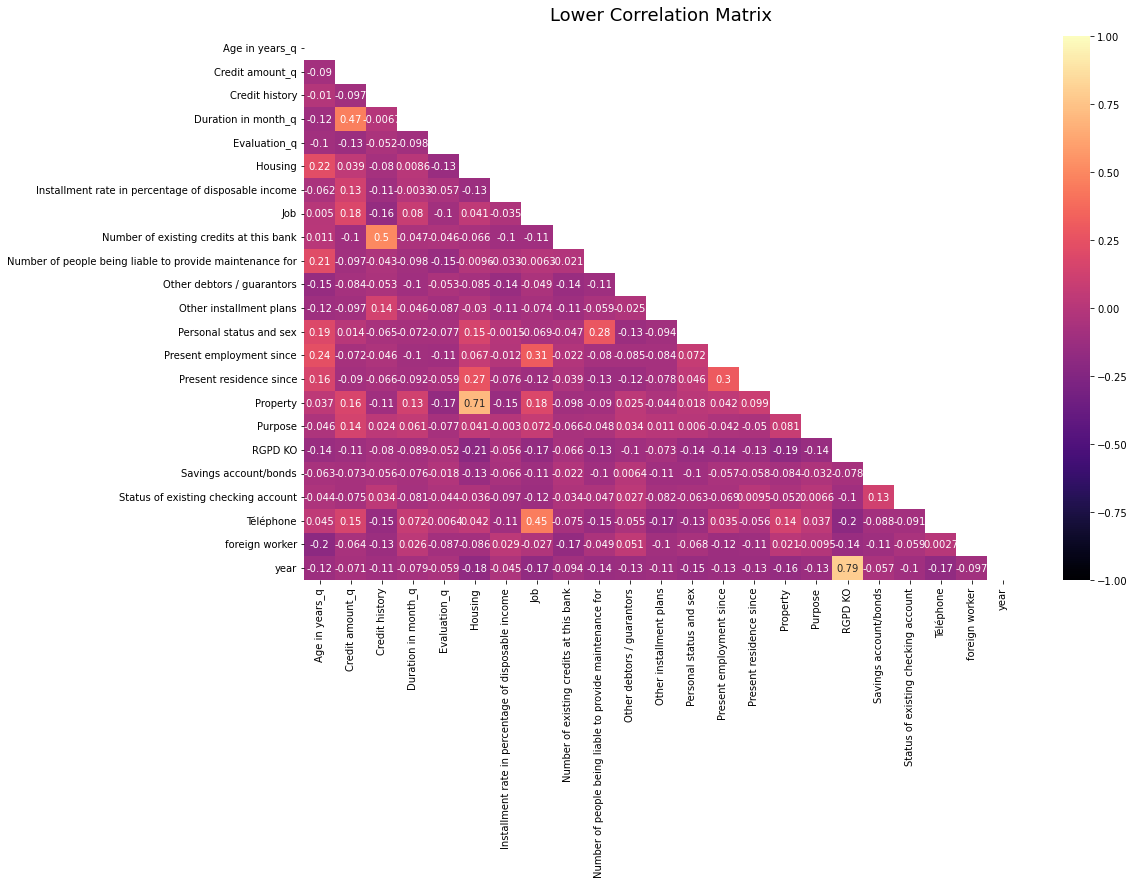

In [23]:
functions_ml.customize_corr(df_corr_matrix)

## Analyse détaillée

- Si les variables corrélées sont quasiement identiques on n'en choisit qu'une.

- sinon si le temps le permet, il faut constituer des variables composite à partir des variables trop corrélés

- on peut regarder les tableaux croisés ci-dessous

- un arbre de décision peut être appliqué pour aller + vite.

In [24]:
pd.pivot_table(df, values='risk', index=['Housing'],
                    columns=['Property'], aggfunc='size')

Property,car or other,real estate,savings agreement/life insurance,unknown / no property
Housing,,,,
for free,NaN,1.0,2.0,86.0
own,219.0,185.0,140.0,27.0
rent,45.0,46.0,35.0,14.0


In [25]:
pd.pivot_table(df, values='risk', index=['Housing'],
                    columns=['Property'], aggfunc=np.mean)

Property,car or other,real estate,savings agreement/life insurance,unknown / no property
Housing,,,,
for free,NaN,1.000000,0.500000,0.395349
own,0.264840,0.216216,0.278571,0.481481
rent,0.488889,0.304348,0.371429,0.500000


In [26]:
df["property_housing"] = df.Housing + "_" + df.Property

# Création des échantillons

- on sépare les données dans plusieurs tables
- on supprime les variables inutiles

## Définition des listes de variables suite à l'analyse dans Excel

In [27]:
numeric_vars = ['Credit amount', 'Age in years', 'Duration in month', 'Evaluation']
other_vars = ['customer_id', 'month']
target = 'risk'
vars_to_delete = ['subsidiary']
qualitative_vars = list(df.columns.difference(numeric_vars + other_vars + vars_to_delete + [ target ]))

#futures variables numériques recodées en qualitative en rajoutant un suffix '_q'
new_qualitative_vars = qualitative_vars + [c + '_q' for c in numeric_vars]

On aurait pu utiliser l'identification basée sur le type de chaque variable dans le dataframe... Mais en général, il faut retoucher manuellement ces listes.

## Création du fichier de train et de test (validation)

In [28]:
df_train = df.sample(frac=0.7,random_state=2022) #random state is a seed value
df_test = df.drop(df_train.index).sample(frac=1.0,random_state=7) #il est préférable de trier la table pour certains algos

print("nb obs:", len(df), "  nb obs in train:", len(df_train), "  nb obs in test:", len(df_test))

#l'instruction génèrera une erreur en cas d'incohérence
assert len(df) == (len(df_train) + len(df_test))

nb obs: 800   nb obs in train: 560   nb obs in test: 240


In [29]:
# On crée une variable temporaire 'sample_flag' qui sera notre variable explicative
df_train['sample_flag'] = 'train'
df_test['sample_flag'] = 'test'
# On concatène les deux df
df_train_test = pd.concat([df_train, df_test])

#On regarde quelles variables de notre dataframe ont un lien fort avec cette variable sample_flag.
#Si l'échantillonnage est bien aléatoire, les T de Tschuprow ou les V de Cramer seront faibles.
df_sample_validation =  functions_ml.features_ordering( df_train_test.fillna('')
                                          , feature_names = [target ] + qualitative_vars
                                          , target = 'sample_flag')

#sur ces données german_credit, comme nous avons peu de lignes,
#nous allons trier le tableau par p_value  sinon on dévrait les trier par Vc OU ts  car tous tests devient statistiquement significatifs
#pour voir les variables qui ont les distributions les + différentes entre le train et le test
df_sample_validation =  df_sample_validation.sort_values('p_value')
print(df_sample_validation)

         target                                           variable      VC      TS     CHI2  p_value
5   sample_flag                                       Evaluation_q  0.1277  0.0903  13.0357   0.0111
7   sample_flag  Installment rate in percentage of disposable i...  0.1121  0.0852  10.0510   0.0181
17  sample_flag                                            Purpose  0.1504  0.0868  18.0993   0.0340
3   sample_flag                                     Credit history  0.0999  0.0707   7.9905   0.0919
11  sample_flag                         Other debtors / guarantors  0.0723  0.0608   4.1873   0.1232
21  sample_flag                                          Téléphone  0.0483  0.0483   1.8696   0.1715
24  sample_flag                                               year  0.0877  0.0620   6.1556   0.1878
1   sample_flag                                     Age in years_q  0.0863  0.0610   5.9560   0.2025
19  sample_flag                              Savings account/bonds  0.0854  0.0604   5.8285

Export de ces résulats dans Excel, puis ils iront en annexe du rapport.

In [30]:
df_sample_validation.to_excel(rep_intermed + 'validation_echantillon_vc_et_ts.xlsx', index=False)

En cas de valeurs fortes de VC ou TS ou de proba faible
- on peut afficher les tableaux de fréquences sur les variables les + problématiques pour se rassurer ou comprendre le potentiel problème
- on pourrait utiliser un échantillon stratifié sur ses variables  pour éviter les problèmes.

In [31]:
# Par exemple, ici sur les 5 variables avec les + grand TS
for c in df_sample_validation['variable'][:5]:
    print("--------------------------------------------")
    print('variable : ' + c )
    print("--------------------------------------------")
    df_temp = pd.crosstab(df_train_test[c], df_train_test['sample_flag'], normalize='columns').reset_index()
    
    print(df_temp.to_string(index=False))
    print()

--------------------------------------------
variable : Evaluation_q
--------------------------------------------
  Evaluation_q     test    train
(24.68, 45.66] 0.125000 0.232143
(45.66, 62.78] 0.237500 0.183929
(5.199, 24.68] 0.204167 0.198214
(62.78, 81.82] 0.216667 0.192857
 (81.82, 99.9] 0.216667 0.192857

--------------------------------------------
variable : Installment rate in percentage of disposable income
--------------------------------------------
 Installment rate in percentage of disposable income     test    train
                                                   1 0.087500 0.153571
                                                   2 0.258333 0.221429
                                                   3 0.133333 0.175000
                                                   4 0.520833 0.450000

--------------------------------------------
variable : Purpose
--------------------------------------------
            Purpose     test    train
           business 0.054167 0.

Petits nettoyages

In [32]:
#suppression de la table (mais en fait elle n'est pas supprimée de la mémoire tout de suite ...
#il faut attendre le garbage collector)
del df_train_test

#suppression de la variable désormais inutile
df_train.drop('sample_flag', axis=1, inplace=True)
df_test.drop('sample_flag', 1, inplace=True)

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_3696/2579686374.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_test.drop('sample_flag', 1, inplace=True)


Pour l'exemple on ne prend que 2 des 3 premières variables les + importantes au sens du Chi2



## Validation de l'échantillonage

- On s'assure que l'échantillon de train et de test se ressemblent.

- Ensuite on ne devra plus utiliser l'échantillon de test sauf à la toute dernière étape où l'on hésite entre quelques modèles par exemple.

In [33]:
# On crée une variable temporaire 'sample_flag' qui sera notre variable explicative
df_train['sample_flag'] = 'train'
df_test['sample_flag'] = 'test'
# On concatène les deux df
df_train_test = pd.concat([df_train, df_test])

#On regarde quelles variables de notre dataframe ont un lien fort avec cette variable sample_flag.
#Si l'échantillonnage est bien aléatoire, les T de Tschuprow ou les V de Cramer seront faibles.
df_sample_validation =  functions_ml.features_ordering( df_train_test.fillna('')
                                          , feature_names = [target ] + qualitative_vars
                                          , target = 'sample_flag')

#sur ces données german_credit, comme nous avons peu de lignes,
#nous allons trier le tableau par p_value  sinon on dévrait les trier par Vc OU ts  car tous tests devient statistiquement significatifs
#pour voir les variables qui ont les distributions les + différentes entre le train et le test
df_sample_validation =  df_sample_validation.sort_values('p_value')
print(df_sample_validation)

         target                                           variable      VC      TS     CHI2  p_value
5   sample_flag                                       Evaluation_q  0.1277  0.0903  13.0357   0.0111
7   sample_flag  Installment rate in percentage of disposable i...  0.1121  0.0852  10.0510   0.0181
17  sample_flag                                            Purpose  0.1504  0.0868  18.0993   0.0340
3   sample_flag                                     Credit history  0.0999  0.0707   7.9905   0.0919
11  sample_flag                         Other debtors / guarantors  0.0723  0.0608   4.1873   0.1232
21  sample_flag                                          Téléphone  0.0483  0.0483   1.8696   0.1715
24  sample_flag                                               year  0.0877  0.0620   6.1556   0.1878
1   sample_flag                                     Age in years_q  0.0863  0.0610   5.9560   0.2025
19  sample_flag                              Savings account/bonds  0.0854  0.0604   5.8285

==========>Good news 

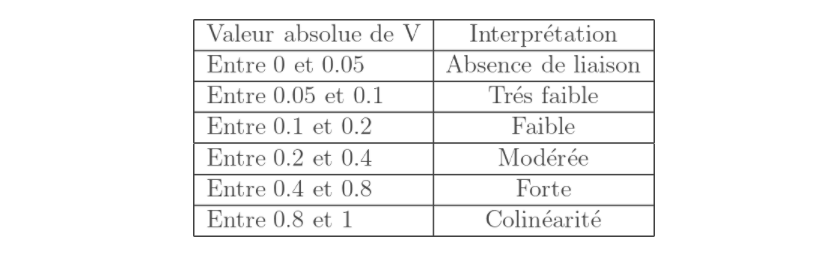

In [34]:
from IPython.display import Image
Image("V_crammer.PNG")

Export de ces résulats dans Excel, puis ils iront en annexe du rapport.

In [35]:
df_sample_validation.to_excel(rep_intermed + 'validation_echantillon_vc_et_ts.xlsx', index=False)

En cas de valeurs fortes de VC ou TS ou de proba faible
- on peut afficher les tableaux de fréquences sur les variables les + problématiques pour se rassurer ou comprendre le potentiel problème
- on pourrait utiliser un échantillon stratifié sur ses variables  pour éviter les problèmes.

In [36]:
# Par exemple, ici sur les 5 variables avec les + grand TS
for c in df_sample_validation['variable'][:5]:
    print("--------------------------------------------")
    print('variable : ' + c )
    print("--------------------------------------------")
    df_temp = pd.crosstab(df_train_test[c], df_train_test['sample_flag'], normalize='columns').reset_index()
    
    print(df_temp.to_string(index=False))
    print()

--------------------------------------------
variable : Evaluation_q
--------------------------------------------
  Evaluation_q     test    train
(24.68, 45.66] 0.125000 0.232143
(45.66, 62.78] 0.237500 0.183929
(5.199, 24.68] 0.204167 0.198214
(62.78, 81.82] 0.216667 0.192857
 (81.82, 99.9] 0.216667 0.192857

--------------------------------------------
variable : Installment rate in percentage of disposable income
--------------------------------------------
 Installment rate in percentage of disposable income     test    train
                                                   1 0.087500 0.153571
                                                   2 0.258333 0.221429
                                                   3 0.133333 0.175000
                                                   4 0.520833 0.450000

--------------------------------------------
variable : Purpose
--------------------------------------------
            Purpose     test    train
           business 0.054167 0.

Petits nettoyages

In [37]:
#suppression de la table (mais en fait elle n'est pas supprimée de la mémoire tout de suite ...
#il faut attendre le garbage collector)
del df_train_test

#suppression de la variable désormais inutile
df_train.drop('sample_flag', axis=1,inplace=True)
df_test.drop('sample_flag', 1, inplace=True)

C:\Users\U32118~1\AppData\Local\Temp/ipykernel_3696/3574098127.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_test.drop('sample_flag', 1, inplace=True)


# MODELISATION

## Calcul du modèle logit avec statsmodels

- utilisation d'une formule de spécification du modèle ressemblant à R
- indiquer les variables catégorielles entre C()
- statsmodels prend la 1ère modalité comme référence
- statsmodels n'a pas l'air d'aimer les variables avec des espaces donc on les remplace par un '_'

In [38]:
# statsmodels n'a pas l'air d'aimer les variables avec des espaces donc on les remplace par un '_'
df_train.columns = [ c.replace(' ','_').replace('/','_') for c in df_train.columns ]
df_test.columns = [ c.replace(' ','_').replace('/','_') for c in df_test.columns ]

## Tests sur plusieurs cas

In [39]:
modele = 'risk ~'
test = 0
results = []
for feature in df_vc['variable'].str.replace(' ','_').str.replace('/','_').to_list():
    modele= modele  +   ' + C({})'.format(feature)
    Res = smf.logit(formula = str(modele)   , data = df_train).fit()
    pred_proba_test = Res.predict(df_test)
    pred_proba_train = Res.predict(df_train)
    results.append((
                    modele, 
                    feature,
                    round(roc_auc_score(df_train['risk'], pred_proba_train), 4),
                    round(roc_auc_score(df_test['risk'], pred_proba_test), 4),
                    round(accuracy_score(df_train['risk'], round( pred_proba_train)), 2),
                    round(accuracy_score(df_test['risk'], round( pred_proba_test)), 2),
                    round(precision_score(df_train['risk'], round( pred_proba_train)), 2),
                    round(precision_score(df_test['risk'], round( pred_proba_test)), 2),
                    round(recall_score(df_train['risk'], round( pred_proba_train)), 2),
                    round(recall_score(df_test['risk'], round( pred_proba_test)), 2),
                    round(f1_score(df_train['risk'], round( pred_proba_train)), 2),
                    round(f1_score(df_test['risk'], round( pred_proba_test)), 2)
    ))
    
df_score= pd.DataFrame(data = results, columns = [ 
                                                  'Modele','variable', 'AUC Train', 'AUC Test', 'Accuracy Train',
                                                  'Accuracy Test','Precision Train', 'Precision Test','Recall Train',
                                                  'Recall Test','F1 Train', 'F1 Test'
                                                  ]
                      )    
df_score

C:\Users\u32118508\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\u32118508\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimization terminated successfully.
         Current function value: 0.537529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446950
  

,Modele,variable,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,risk ~ + C(Status_of_existing_checking_account),Status_of_existing_checking_account,0.7084,0.6617,0.71,0.68,0.00,0.00,0.00,0.00,0.00,0.00
1,risk ~ + C(Status_of_existing_checking_account...,Credit_history,0.7501,0.6989,0.74,0.70,0.66,0.80,0.20,0.10,0.31,0.18
2,risk ~ + C(Status_of_existing_checking_account...,Duration_in_month_q,0.7794,0.7219,0.77,0.70,0.65,0.57,0.46,0.29,0.54,0.39
3,risk ~ + C(Status_of_existing_checking_account...,Savings_account_bonds,0.7952,0.7342,0.78,0.70,0.68,0.59,0.48,0.26,0.56,0.36
4,risk ~ + C(Status_of_existing_checking_account...,Housing,0.7997,0.7258,0.77,0.70,0.65,0.61,0.50,0.26,0.56,0.36
5,risk ~ + C(Status_of_existing_checking_account...,Purpose,0.8169,0.7445,0.77,0.72,0.65,0.68,0.48,0.29,0.55,0.41
6,risk ~ + C(Status_of_existing_checking_account...,Other_installment_plans,0.8200,0.7549,0.77,0.73,0.65,0.68,0.49,0.33,0.56,0.45
7,risk ~ + C(Status_of_existing_checking_account...,Property,0.8221,0.7426,0.76,0.72,0.63,0.65,0.48,0.28,0.54,0.39
8,risk ~ + C(Status_of_existing_checking_account...,Present_employment_since,0.8253,0.7477,0.78,0.73,0.66,0.68,0.52,0.32,0.59,0.43
9,risk ~ + C(Status_of_existing_checking_account...,Credit_amount_q,0.8336,0.7295,0.78,0.73,0.65,0.66,0.54,0.37,0.59,0.48


## Modèle finale

In [40]:
df_score[df_score['AUC Test'] == df_score['AUC Test'].max()]

,Modele,variable,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
6,risk ~ + C(Status_of_existing_checking_account...,Other_installment_plans,0.82,0.7549,0.77,0.73,0.65,0.68,0.49,0.33,0.56,0.45


In [41]:
# utiliser le meilleur modèle
variable = [
                                             'Status_of_existing_checking_account', 
                                             'Credit_history', 'Duration_in_month_q',
                                             'Savings_account_bonds','Housing',
                                             'Purpose', 'Other_installment_plans'
            ]
best_model = df_score[df_score['AUC Test'] == df_score['AUC Test'].max()].iloc[0,0]
Res = smf.logit(formula = str(best_model)   , data = df_train[variable + ['risk']]).fit()
pred_proba_test = Res.predict(df_test[variable])
pred_proba_train = Res.predict(df_train[variable])

Optimization terminated successfully.
         Current function value: 0.460081
         Iterations 7


In [42]:
df_score[df_score['AUC Test'] == df_score['AUC Test'].max()].iloc[0,0]


'risk ~ + C(Status_of_existing_checking_account) + C(Credit_history) + C(Duration_in_month_q) + C(Savings_account_bonds) + C(Housing) + C(Purpose) + C(Other_installment_plans)'

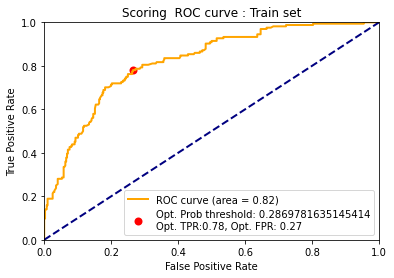

Accuracy: 0.75
Recall: 0.78
precision: 0.55


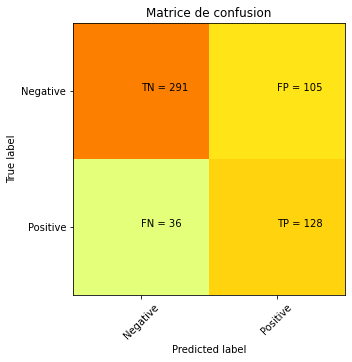

In [43]:
fpr, tpr, thresholds = roc_curve(df_train["risk"], pred_proba_train)
roc_auc = auc(fpr, tpr)
optimal_thr = thresholds[np.argmin((0-fpr)**2 + (1-tpr)**2)]
optimal_tpr = tpr[thresholds==optimal_thr][0]
optimal_fpr = fpr[thresholds==optimal_thr][0]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='orange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(optimal_fpr, optimal_tpr, color="red", lw=lw, label=f"Opt. Prob threshold: {optimal_thr}\nOpt. TPR:{round(optimal_tpr, 2)}, Opt. FPR: {round(optimal_fpr, 2)}")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scoring  ROC curve : Train set')
plt.legend(loc="lower right")
plt.show()
functions_ml.confusio_matrix(df_train["risk"], (pred_proba_train>= optimal_thr).astype(int))

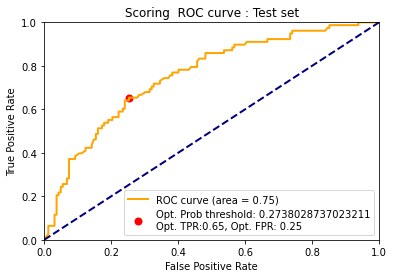

Accuracy: 0.72
Recall: 0.65
precision: 0.55


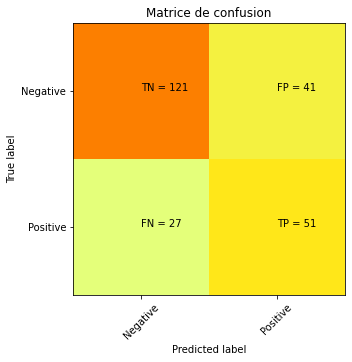

In [44]:
fpr, tpr, thresholds = roc_curve(df_test["risk"], pred_proba_test)
roc_auc = auc(fpr, tpr)
optimal_thr = thresholds[np.argmin((0-fpr)**2 + (1-tpr)**2)]
optimal_tpr = tpr[thresholds==optimal_thr][0]
optimal_fpr = fpr[thresholds==optimal_thr][0]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='orange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(optimal_fpr, optimal_tpr, color="red", lw=lw, label=f"Opt. Prob threshold: {optimal_thr}\nOpt. TPR:{round(optimal_tpr, 2)}, Opt. FPR: {round(optimal_fpr, 2)}")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scoring  ROC curve : Test set')
plt.legend(loc="lower right")
plt.show()

functions_ml.confusio_matrix(df_test["risk"], (pred_proba_test >= optimal_thr).astype(int))

In [45]:
# Seuil optimale qui maximise le taux dde vrai positive et minimise et le taux de faux positif est = 0.36
print(Res.summary())

                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  560
Model:                          Logit   Df Residuals:                      531
Method:                           MLE   Df Model:                           28
Date:                Sun, 13 Feb 2022   Pseudo R-squ.:                  0.2391
Time:                        02:17:58   Log-Likelihood:                -257.65
converged:                       True   LL-Null:                       -338.63
Covariance Type:            nonrobust   LLR p-value:                 8.315e-21
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -0.3986      0.853     -0.467      0.640   

# Exportation du modèle

In [46]:
# MODELE
f=open(rep_intermed+"scoring.pkl","wb")
pickle.dump(Res ,f)
f.close()
# Assignement optimal
g=open(rep_intermed+"treshold.pkl","wb")
pickle.dump(optimal_thr ,g)
g.close()